In [1]:
from omegaconf import OmegaConf
import torchvision.transforms as transforms
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl

from src.models.project1.train_model import train
from src.utils import set_seed
from src.data.project1.dataloader import get_loaders, get_normalization_constants
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateFinder

from src.models.project1.models import get_model
import matplotlib.pylab as plt
import sys




In [ ]:
!{sys.executable} -m pip install -e GitHub/DL-COMVIS

# Arguments

In [5]:
# Define arguments
args = OmegaConf.create({
    'experiment_name': 'test123',
    'network_name': 'initial',

    'data_path': '/dtu/datasets1/02514/hotdog_nothotdog/',
    'log_path': '/work3/s194262/02514/DL-COMVIS/logs/project1',
    'save_path': '/work3/s194262/02514/DL-COMVIS/models/project1',
    
    'seed': 0,
    'verbose': False,
    'log_every_n': 2,

    'batch_size': 32,
    'optimizer': 'Adam',
    'lr': 0.005,
    'min_lr': 0.00000001,
    'max_lr': 0.1,
    'initial_lr_steps': 10,

    'epochs': 5,
    'num_workers': 24, 
    'devices': -1, 
})

# Train

In [ ]:
# Train model
train(args)

# Step-wise

In [2]:

def get_network(network_name: str, args):

    def norm(norm_type, layer_num, num_features):
        if norm_type == 'batchnorm':
            return (f'bn{layer_num}', nn.BatchNorm2d(num_features))
        if norm_type == 'layernorm':
            # image shaped divided by 2 ** number of times we've done maxpooling
            channel_dim = 224 / 2**(layer_num - 1)
            return (f'ln{layer_num}', nn.LayerNorm([num_features, channel_dim, channel_dim])),
        if norm_type == 'instancenorm':
            return (f'in{layer_num}', nn.InstanceNorm2d(num_features)),

    if network_name == 'test':
        return nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('conv2', nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('conv3', nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)),
            ('relu3', nn.ReLU()),
            ('pool3', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('flatten', nn.Flatten()),
            ('fc1', nn.Linear(64 * 28 * 28, 256)),
            ('relu4', nn.ReLU()),
            ('fc2', nn.Linear(256, 2))
        ]))

    elif network_name == 'initial':
        return nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)),
            norm(norm_type = args.norm, layer_num = 1, num_features = 16),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('dropout1', nn.Dropout(p=0.2)),
            
            ('conv2', nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)),
            norm(norm_type = args.norm, layer_num = 2, num_features = 32),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('dropout2', nn.Dropout(p=0.2)),
            
            ('conv3', nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)),
            norm(norm_type = args.norm, layer_num = 3, num_features = 64),
            ('relu3', nn.ReLU()),
            ('pool3', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('dropout3', nn.Dropout(p=0.2)),
            
            ('conv4', nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)),
            norm(norm_type = args.norm, layer_num = 4, num_features = 128),
            ('relu4', nn.ReLU()),
            ('pool4', nn.MaxPool2d(kernel_size=2, stride=2)),
            ('dropout4', nn.Dropout(p=0.2)),
            
            ('flatten', nn.Flatten()),
            ('fc1', nn.Linear(128 * 14 * 14, 256)),
            ('relu4', nn.ReLU()),
            ('dropout5', nn.Dropout(p=0.2)),
            ('fc2', nn.Linear(256, 2))
        ]))
	

    else:
        raise NotImplementedError("Not defined yet...")

In [6]:
model = get_model(network_name=args.network_name)(args)


In [4]:
model = get_model(network_name=args.network_name)(args)
model.lr_finder = LearningRateFinder(
    min_lr=args.min_lr,
    max_lr=args.max_lr,
    num_training_steps=args.initial_lr_steps,
    early_stop_threshold=False
)


In [12]:

# Set random seed
set_seed(args.seed)

# Load model
model = get_model(network_name=args.network_name)(args)

# Get normalization constants
train_mean, train_std = get_normalization_constants(root=args.data_path, seed=args.seed)

# Define transforms for training
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.5),             # flips "left-right"
    # transforms.RandomVerticalFlip(p=1.0),             # flips "upside-down"
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # transforms.RandomRotation(degrees=(60, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=train_mean, 
        std=train_std, 
    )
])

# Define transforms for test and validation
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=train_mean, 
        std=train_std, 
    )
])

# Get data loaders with applied transformations
loaders = get_loaders(
    root=args.data_path, 
    batch_size=args.batch_size, 
    seed=args.seed, 
    train_transforms=train_transforms, 
    test_transforms=test_transforms, 
    num_workers=args.num_workers,
)

# Set up logger
tb_logger = TensorBoardLogger(
    save_dir=f"{args.log_path}/{args.experiment_name}",
    version=None,
    name=args.network_name,
)

# Setup trainer
trainer = pl.Trainer(
    devices=args.devices, 
    accelerator="gpu", 
    max_epochs = args.epochs,
    log_every_n_steps = args.log_every_n,
    callbacks=[model.model_checkpoint, model.lr_finder],
    logger=tb_logger,
) 

# Train model
trainer.fit(
    model=model,
    train_dataloaders = loaders['train'],
    val_dataloaders = loaders['validation'], 
) 


Computing mean of training split...: 100%|█| 1638/1638 [00:05<00:00,
Computing std. dev. of training split...: 100%|█| 1638/1638 [00:06<0



Mean: tensor([0.5132, 0.4369, 0.3576])
Std. dev.: tensor([0.0214, 0.0208, 0.0223])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Finding best initial lr:   0%|          | 0/10 [00:00<?, ?it/s]

LR finder stopped early after 8 steps due to diverging loss.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Restoring states from the checkpoint path at /zhome/96/8/147177/GitHub/DL-COMVIS/.lr_find_19891ac3-2a7a-41af-ab87-b74299be3c07.ckpt
Restored all states from the checkpoint at /zhome/96/8/147177/GitHub/DL-COMVIS/.lr_find_19891ac3-2a7a-41af-ab87-b74299be3c07.ckpt

  | Name      | Type              | Params
------------------------------------------------
0 | network   | Sequential        | 6.5 M 
1 | criterion | BCEWithLogitsLoss | 0     
2 | accuracy  | BinaryAccuracy    | 0     
------------------------------------------------
6.5 M     Trainable params
0         Non-trainable params
6.5 M     Total params
26.083    Total estimated model params size (MB)
Restored all states from the checkpoint at /zhome/96/8/147177/GitHub/DL-COMVIS/.lr_find_19891ac3-2a7a-41af-ab87-b7429

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


# Model analysis

In [ ]:
trainer.model.lr_finder.optimal_lr._optimal_idx

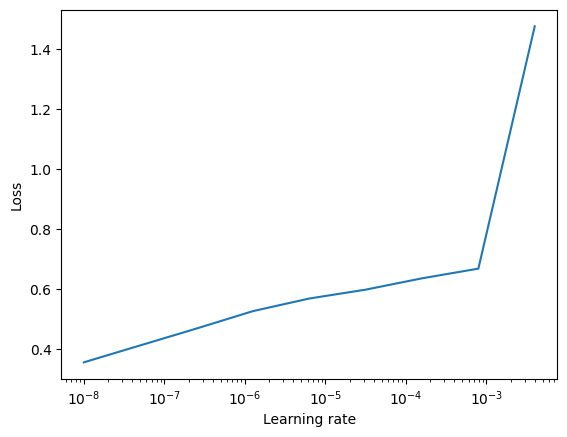

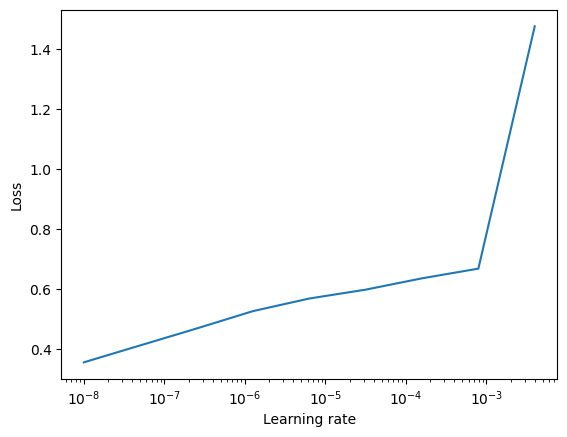

In [29]:
trainer.model.lr_finder.optimal_lr.plot()

In [6]:
# manually you can save best checkpoints - 
trainer.save_checkpoint(f"{args.save_path}/{args.experiment_name}/{args.network_name}.pt")

In [7]:
args.model_path = f"{args.save_path}/{args.experiment_name}/{args.network_name}.pt"

In [8]:
model_final = model.load_from_checkpoint(args.model_path, args=args)


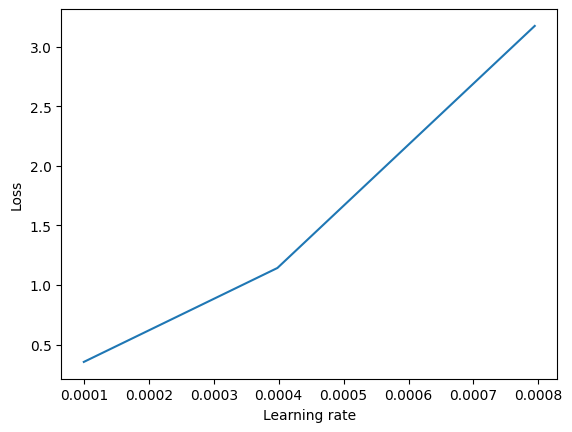

In [68]:
sweep = trainer.model.lr_finder.optimal_lr.results

plt.plot(sweep['lr'], sweep['loss'])
plt.xlabel('Learning rate');plt.ylabel('Loss')
plt.show()